In [1]:
# Parameters
run = "18_punishment_autoregressive_v2"
base_folder = "behavioral_cloning"
target = "punishment"
test = "t-test_paired"
selection = {"architecture": "node+edge+rnn"}
comparision = "architecture"
groups = [{}]
order = ["node", "node+edge", "node+rnn", "node+edge+rnn"]
pairs = [
    ["node", "node+edge"],
    ["node", "node+rnn"],
    ["node+edge", "node+rnn"],
    ["node+rnn", "node+edge+rnn"],
    ["node+edge", "node+edge+rnn"],
    ["node", "node+edge+rnn"],
]
output_dir = (
    "notebooks/evalutation/predictive_models_autoreg/18_punishment_autoregressive_v2"
)
basedir = "."


In [2]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch as th
import matplotlib.pyplot as plt
from aimanager.utils.utils import make_dir
from aimanager.utils.merge import merge_files_by_name

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

data_folder = os.path.join(basedir, 'data', base_folder, run)
if "output_dir" in locals():
    plot_folder = output_dir
else:
    plot_folder = os.path.join(basedir, 'plots', base_folder, run)

make_dir(plot_folder)

In [3]:
def _plot_heatmap(data, x, y, values, normalise=True):
    dfg = data.groupby([x,y])[values].sum()
    dfg = dfg.reset_index()
    if normalise:
        dfg[values] = dfg[values] / dfg.groupby([x])[values].transform('sum')
    cm = dfg.pivot_table(index=x, columns=y, values=values)
    cm = cm.sort_index(ascending=False)
    sns.heatmap(cm)

def merge_data(data_folder, metric_name):
    folder = os.path.join(data_folder, metric_name)
    dfs = [pd.read_parquet(os.path.join(folder, file)) for file in os.listdir(folder)]
    df = pd.concat(dfs).reset_index(drop=True)
    return df


In [4]:
metrics_df = merge_data(data_folder, 'metrics')
print(metrics_df['cv_split'].unique())
try:
    confusion_matrix_df = merge_data(data_folder, 'confusion_matrix')
except:
    confusion_matrix_df = None
metrics_df['shuffle_feature'] = metrics_df['shuffle_feature'].fillna('none')
labels = list(set(metrics_df.columns) - set(['job_id', 'name', 'value', 'cv_split', 'epoch', 'set', 'strategy', 'shuffle_feature', 'mask', 'n_pred']))

print(labels)


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]


['architecture']


<Figure size 640x480 with 0 Axes>

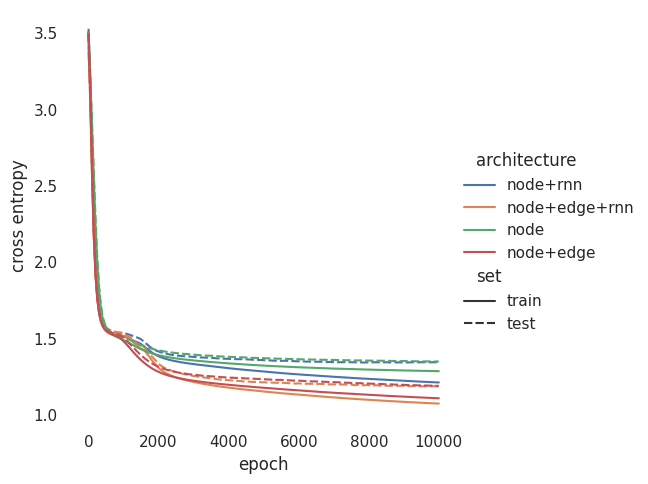

<Figure size 640x480 with 0 Axes>

In [5]:

plt.clf()
df = metrics_df.copy()


focus = [*labels, 'set']

sel = {
    'name': 'log_loss',
    'shuffle_feature': 'none',
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

fg = sns.relplot(
    data=df, 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'learning_curve_model.jpg'))
plt.show()
plt.clf()

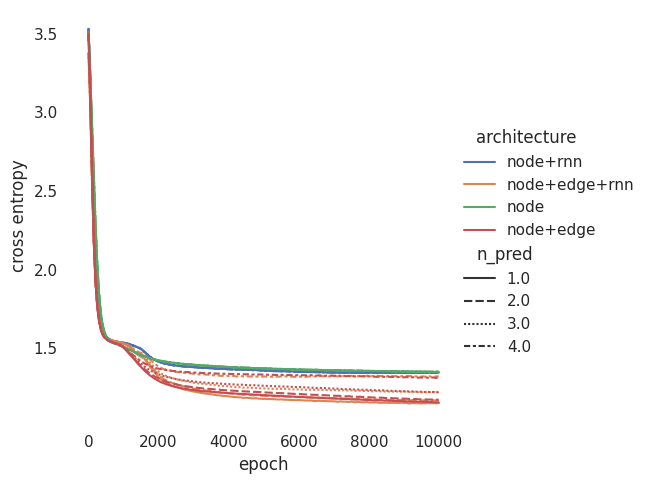

<Figure size 640x480 with 0 Axes>

In [6]:
df = metrics_df.copy()


focus = [*labels, 'n_pred']

sel = {
    'set': 'test',
    'name': 'log_loss',
    'shuffle_feature': 'none',
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

fg = sns.relplot(
    data=df, 
    x='epoch', y='value',
    hue=focus[0] if len(focus) >= 1 else None, 
    style=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='line', ci=None)

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'learning_curve_model_npred.jpg'))
plt.show()
plt.clf()

In [7]:
import statsmodels.formula.api as smf


df = metrics_df.copy()

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()

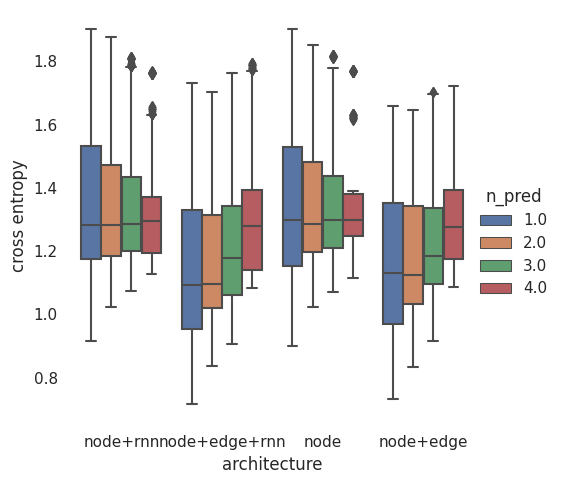

<Figure size 640x480 with 0 Axes>

In [8]:
df = metrics_df.copy()

# focus = labels[:1] + ['n_pred'] + labels[1:]
focus = labels + ['n_pred']

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()


fg = sns.catplot(
    data=df, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'cross_entropy_box.jpg'))
plt.show()
plt.clf()

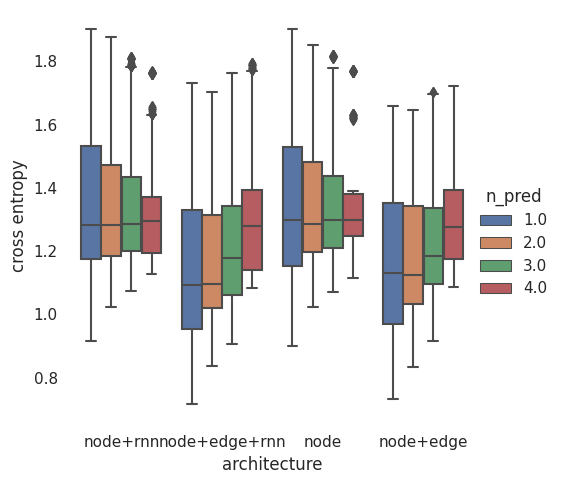

<Figure size 640x480 with 0 Axes>

In [9]:
df = metrics_df.copy()

focus = [*labels, 'n_pred']

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') &
    (df['shuffle_feature'] == 'none')
)
df = df[w].copy()
w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()


fg = sns.catplot(
    data=df, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'cross_entropy_box_npred.jpg'))
plt.show()
plt.clf()

In [10]:
df = metrics_df.copy()

if 'n_predicted' in df.columns:

    focus = [*labels]

    w = (
        (df['name'] == 'log_loss') &
        (df['set'] == 'test') &
        (df['shuffle_feature'] == 'none') &
        (df['n_pred'] == df['n_predicted'])
    )
    df = df[w].copy()
    w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
    df = df[w_max].copy()


    fg = sns.catplot(
        data=df, 
        y='value',
        x=focus[0] if len(focus) >= 1 else None, 
        hue=focus[1] if len(focus) >= 2 else None,
        col=focus[2] if len(focus) >= 3 else None, 
        row=focus[3] if len(focus) >= 4 else None, 
        kind='box')

    fg.set(ylabel='cross entropy')

    fg.savefig(os.path.join(plot_folder, 'cross_entropy_box_npred.jpg'))
    plt.show()
    plt.clf()

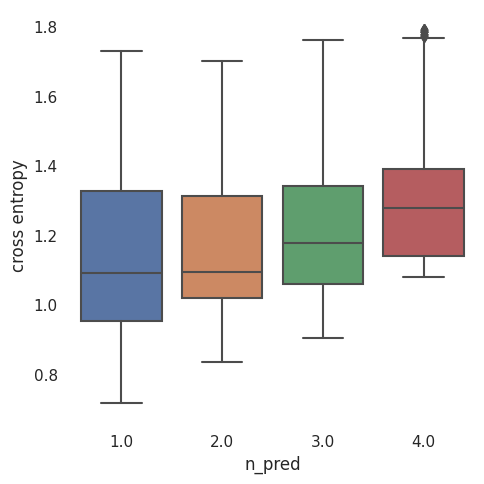

<Figure size 640x480 with 0 Axes>

In [11]:
df = metrics_df.copy()

focus = ['n_pred']


sel = {
    'name': 'log_loss',
    'set': 'test',
    'shuffle_feature': 'none',
    **selection
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)
df = df[w].copy()

w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
df = df[w_max].copy()


fg = sns.catplot(
    data=df, 
    y='value',
    x=focus[0] if len(focus) >= 1 else None, 
    hue=focus[1] if len(focus) >= 2 else None,
    col=focus[2] if len(focus) >= 3 else None, 
    row=focus[3] if len(focus) >= 4 else None, 
    kind='box')

fg.set(ylabel='cross entropy')

fg.savefig(os.path.join(plot_folder, 'cross_entropy_box_npred.jpg'))
plt.show()
plt.clf()

node vs. node+edge: t-test paired samples, P_val:2.270e-05 t=7.975e+00


node+edge vs. node+rnn: t-test paired samples, P_val:8.616e-05 t=-6.724e+00
node+rnn vs. node+edge+rnn: t-test paired samples, P_val:7.438e-06 t=9.153e+00


node vs. node+rnn: t-test paired samples, P_val:2.635e-01 t=1.193e+00


node+edge vs. node+edge+rnn: t-test paired samples, P_val:4.802e-01 t=7.365e-01


node vs. node+edge+rnn: t-test paired samples, P_val:2.226e-06 t=1.058e+01


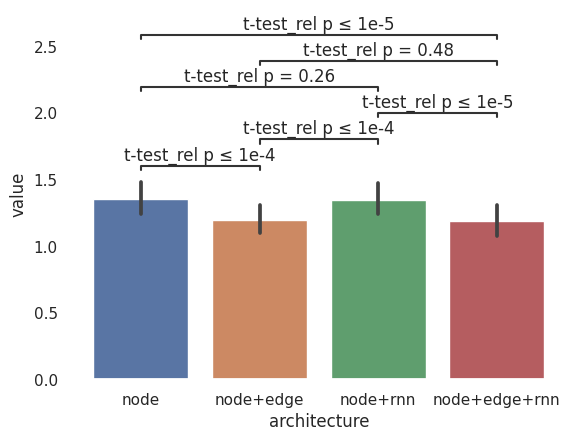

<Figure size 640x480 with 0 Axes>

In [12]:
from statannotations.Annotator import Annotator

for g in groups:
    df = metrics_df.copy()
    name = ''.join(g.values())
    sel = {
        'name': 'log_loss',
        'set': 'test',
        'shuffle_feature': 'none',
        **g
    }

    w = pd.concat(
        (df[k].isin(v) if isinstance(v, list) else df[k] == v
        for k,v in sel.items()
        if (k not in focus) or isinstance(v, list)), axis=1
    ).all(1)

    df = df[w].copy()
    w_max = (df['epoch'] > (0.8 * df['epoch'].max()))
    df = df[w_max].copy()

    dfm = df.groupby([comparision, 'cv_split'])['value'].mean().reset_index()
    dfm['mean_value'] = dfm.groupby(comparision)['value'].transform('mean')

    dfm[comparision] = dfm[comparision].astype(str)


    ax = sns.barplot(
        data=dfm, 
        order=order,
        y='value',
        x=comparision
    )
    if pairs is not None:
        annotator = Annotator(ax, pairs, data=dfm, x=comparision, y='value', order=order)
        annotator.configure(test=test, text_format='simple', loc='inside')
        annotator.apply_and_annotate()

    plt.savefig(os.path.join(plot_folder, f'model_comparision_{name}.jpg'))
    plt.show()
    plt.clf()

In [13]:
df = metrics_df.copy()

w = (
    (df['name'] == 'log_loss') &
    (df['set'] == 'test') 
)
df = df[w].copy()

df_p = df.pivot(index=[*labels, 'mask', 'name', 'cv_split', 'set', 'epoch'], columns='shuffle_feature', values='value')
df_p = df_p.sub(df_p['none'], axis=0)
df_p = df_p.stack()
df_p.name = 'value'
df_p = df_p.reset_index()
df_p = df_p[df_p['shuffle_feature'] != 'none']

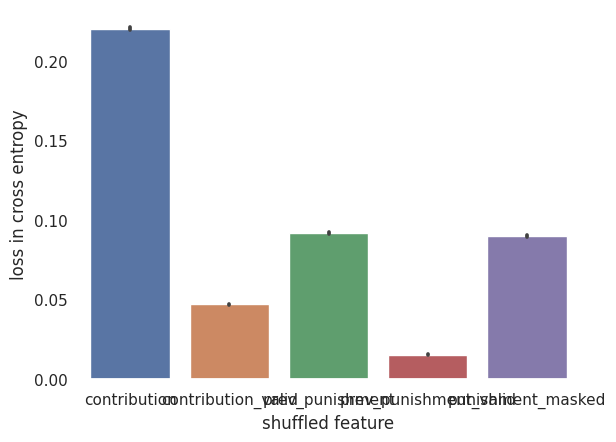

<Figure size 640x480 with 0 Axes>

In [14]:
focus = ['shuffle_feature']

sel = {
    'name': 'log_loss',
    'set': 'test',
    **selection
}

w = pd.concat(
    (df_p[k].isin(v) if isinstance(v, list) else df_p[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)


dfs = df_p[w].copy()

ax = sns.barplot(
    data=df_p, 
    x='shuffle_feature', y='value',
)

ax.set(ylabel='loss in cross entropy', xlabel='shuffled feature')

plt.savefig(os.path.join(plot_folder, 'shuffle_feature_importance.jpg'))
plt.show()
plt.clf()

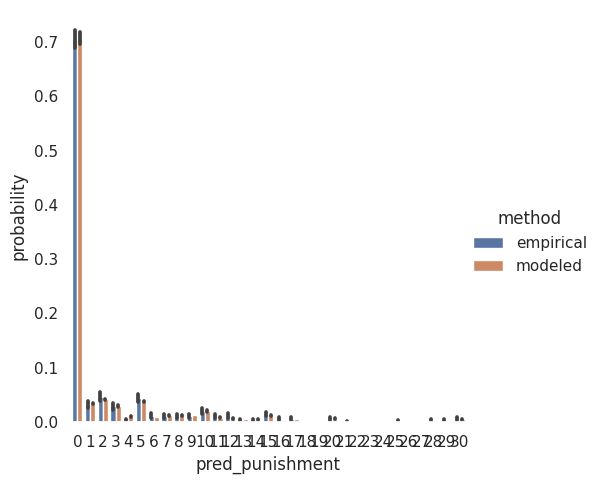

<Figure size 640x480 with 0 Axes>

In [15]:
df = confusion_matrix_df.copy()

sel = {
    'round_number': 0,
    'valid': True,
    'set': 'test',
    **selection
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)


df = df[w]

dfc = df.copy()

dfc['probability'] = df[f'pred_{target}'] == df[f'true_{target}']
dfc['method'] = 'empirical'
df['probability'] = df['proba']
df['method'] = 'modeled'

df = pd.concat([dfc, df]).reset_index()

fg = sns.catplot(
    data=df, 
    x=f'pred_{target}', 
    y='probability',
    hue='method',
    height=5, kind='bar')

fg.savefig(os.path.join(plot_folder, 'action_histogram.jpg'))
plt.show()
plt.clf()

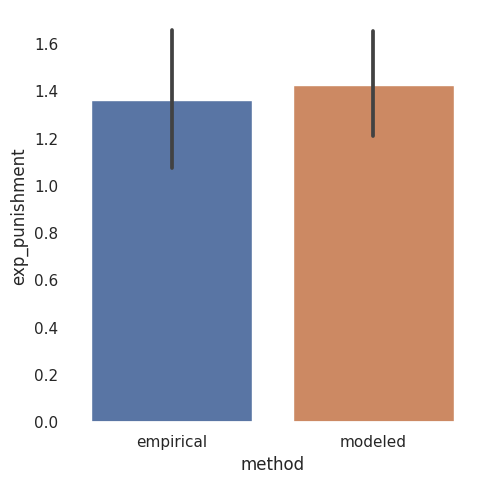

<Figure size 640x480 with 0 Axes>

In [16]:
df = confusion_matrix_df.copy()

sel = {
    'round_number': 0,
    'valid': True,
    'set': 'test',
    **selection
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)


df = df[w]

dfc = df.copy()

dfc['probability'] = df[f'pred_{target}'] == df[f'true_{target}']
dfc['method'] = 'empirical'
df['probability'] = df['proba']

df['method'] = 'modeled'

df = pd.concat([dfc, df]).reset_index()

df[f'exp_{target}'] = df[f'pred_{target}'] * df[f'probability']

dfg = (df.groupby(['method', 'idx', 'round_number', 'set', *labels])[f'exp_{target}'].mean() * 20).reset_index()

fg = sns.catplot(
    data=dfg, 
    y=f'exp_{target}',
    x='method',
    height=5, kind='bar')

plt.show()
plt.clf()

In [17]:
dfg.groupby('method').mean()

/tmp/ipykernel_36854/2399929462.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dfg.groupby('method').mean()


,idx,round_number,exp_punishment
method,,,
empirical,17.5,0.0,1.364994
modeled,17.5,0.0,1.426769


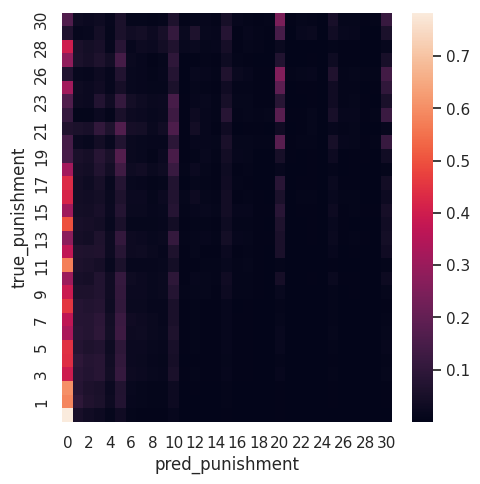

<Figure size 640x480 with 0 Axes>

In [18]:
df = confusion_matrix_df.copy()

sel = {
    'valid': True,
    'set': 'test',
    'n_pred': 4,
    **selection
}

w = pd.concat(
    (df[k].isin(v) if isinstance(v, list) else df[k] == v
    for k,v in sel.items()
    if (k not in focus) or isinstance(v, list)), axis=1
).all(1)

df = df[w]

dfc = df.copy()


plot_heatmap = lambda data, color: _plot_heatmap(
    data, x=f'true_{target}',y=f'pred_{target}', values='proba')

fg = sns.FacetGrid(
    dfc, height=5)
fg.map_dataframe(plot_heatmap)


fg.savefig(os.path.join(plot_folder, 'confusion_matrix.jpg'))
plt.show()
plt.clf()